In [1]:
%%capture
try:
    import pandas  # noqa: F401
except ImportError:
    !pip install pandas

try:
    import numpy  # noqa: F401
except ImportError:
    !pip install numpy

try:
    import matplotlib  # noqa: F401
except ImportError:
    !pip install matplotlib

try:
    import sklearn  # noqa: F401
except ImportError:
    !pip install scikit-learn

try:
    import scipy  # noqa: F401
except ImportError:
    !pip install scipy

try:
    import statsmodels  # noqa: F401
except ImportError:
    !pip install statsmodels

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA

## Model Configuration

In [27]:
context_len = 512
forecast_len = 1
STRIDE = 3
ALPHA = 0.9
NUM_PLOTS = 5

In [28]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv", parse_dates=["date"]
)
df = df.set_index("date")
df.index.freq = pd.infer_freq(df.index)

In [29]:
border1s = [0, 12 * 30 * 24 - context_len, 12 * 30 * 24 + 4 * 30 * 24 - context_len]

border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]

## Loading Data

In [30]:
data = df[["OT"]].values
scaler = StandardScaler()
train_data = data[border1s[0] : border2s[0], :]
scaler = StandardScaler()
scaler.fit(train_data)


data = scaler.transform(data)
valid_data = data[border1s[1] : border2s[1], :]
test_data = data[border1s[2] : border2s[2] : STRIDE, :]

## Implements EMA


In [31]:
def get_ema_forecast(context, alpha=ALPHA):
    s_t = context[0, :]
    for t in range(1, context.shape[0]):
        s_t = alpha * context[t, :] + (1 - alpha) * s_t
    return s_t

In [32]:
summary = []
for idx, _ in enumerate(test_data):
    if idx + context_len + forecast_len < test_data.shape[0]:
        context = test_data[idx : idx + context_len, :]
        actual = test_data[idx + context_len : idx + context_len + forecast_len, :]
        forecast = get_ema_forecast(context)
        summary.append((context, actual, np.array([forecast])))

In [33]:
actual = [i[1][0, 0] for i in summary]
forecast = [i[2][0, 0] for i in summary]

In [34]:
print(np.round(mse(actual, forecast), 5))

0.00956


In [35]:
random_indices = np.random.default_rng(1).choice(len(summary), size=NUM_PLOTS, replace=False)

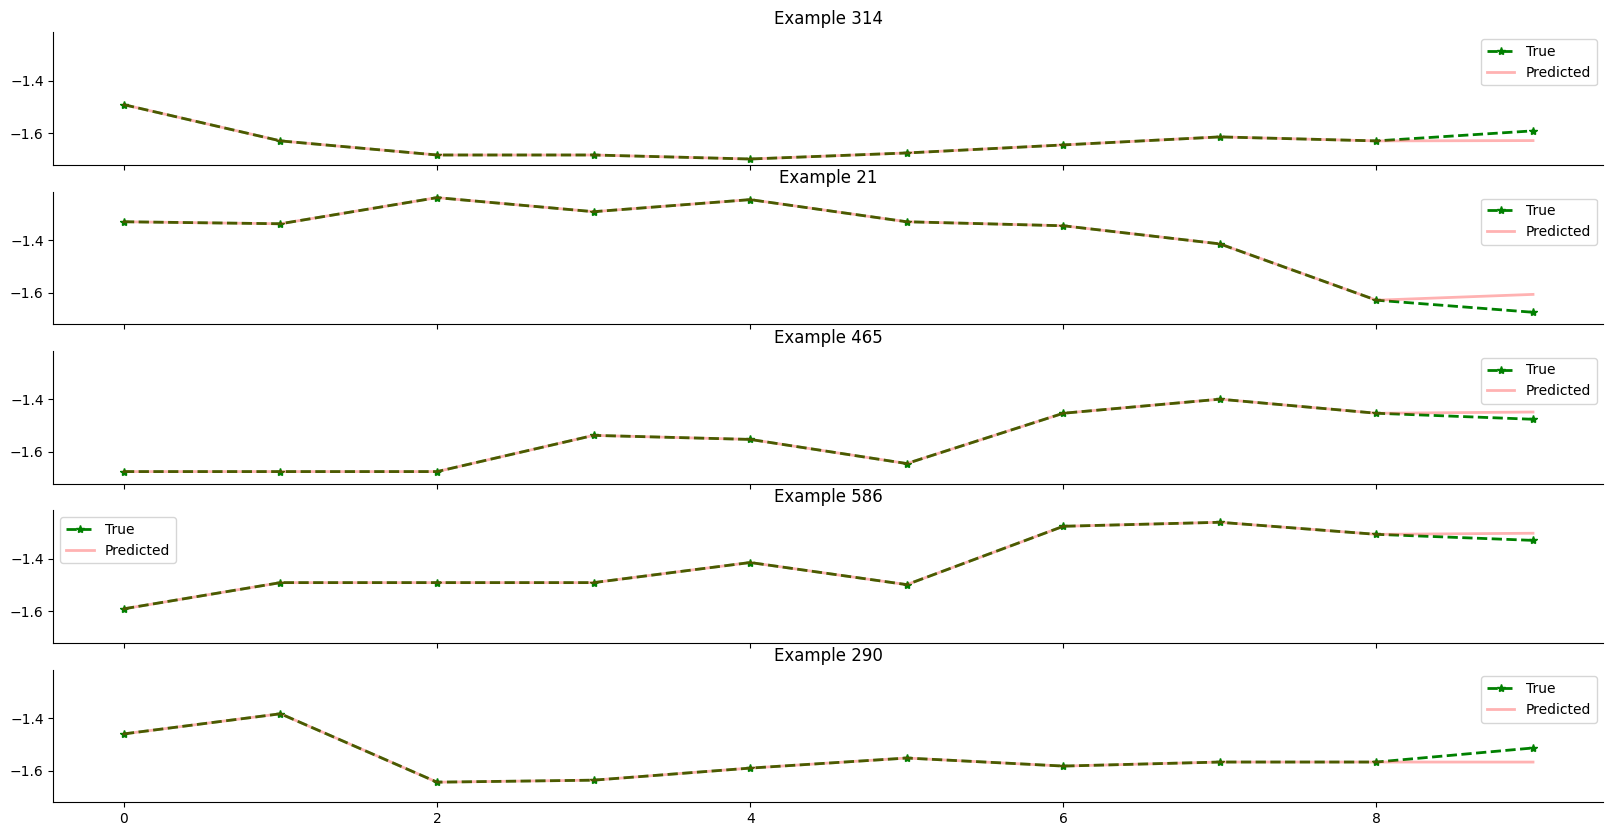

In [36]:
last_pts = 10
fig, axs = plt.subplots(len(random_indices), 1, sharex="col", sharey=True, figsize=(20, len(random_indices) * 2))
for i, ri in enumerate(random_indices):
    act = np.concatenate((summary[ri][0], summary[ri][1]), axis=0)
    fcast = np.concatenate((summary[ri][0], summary[ri][2]), axis=0)
    axs[i].plot(act[-last_pts:, :], label="True", linestyle="--", marker="*", color="green", linewidth=2)
    axs[i].plot(fcast[-last_pts:, :], label="Predicted", linestyle="-", color="red", linewidth=2, alpha=0.3)
    axs[i].set_title(f"Example {random_indices[i]}")
    # axs[i].set_ylim(-3, 3)
    for s in ["top", "right"]:
        axs[i].spines[s].set_visible(False)
    axs[i].legend()

## ARMA on ETT Dataset

In [37]:
def get_arma_forecast(context, p=1, r=0, q=0):
    arma = ARIMA(context, order=(p, r, q)).fit(method_kwargs={"warn_convergence": False})
    predict_etth1_ot = arma.predict(context.shape[0] + 1, context.shape[0] + 1)
    return predict_etth1_ot

In [38]:
context_len = 512
arma_summary = []
for idx, _ in enumerate(test_data):
    if idx + context_len + forecast_len < test_data.shape[0]:
        context = test_data[idx : idx + context_len, :]
        actual = test_data[idx + context_len : idx + context_len + forecast_len, :]
        forecast = get_arma_forecast(context)
        arma_summary.append((context, actual, np.array([forecast])))
        if idx % 100 == 0:
            print(f"# of forecasts so far {idx}", actual[0, 0], forecast[0])

# of forecasts so far 0 -1.2992179488425548 -1.2680389483123822
# of forecasts so far 100 -1.4755380463287084 -1.4435713803112926
# of forecasts so far 200 -1.506268754186788 -1.5379047387918552
# of forecasts so far 300 -1.5906147124974481 -1.5461646291990956
# of forecasts so far 400 -2.0122355768050104 -1.7900986171689126
# of forecasts so far 500 -1.3989292610822546 -1.4205858106630265
# of forecasts so far 600 -1.536890469845495 -1.395570075202583


In [39]:
arma_actual = [i[1][0, 0] for i in arma_summary]
arma_forecast = [i[2][0, 0] for i in arma_summary]

In [40]:
print(np.round(mse(arma_actual, arma_forecast), 5))

0.01027


In [41]:
arma_random_indices = np.random.default_rng(1).choice(len(arma_summary), size=NUM_PLOTS, replace=False)

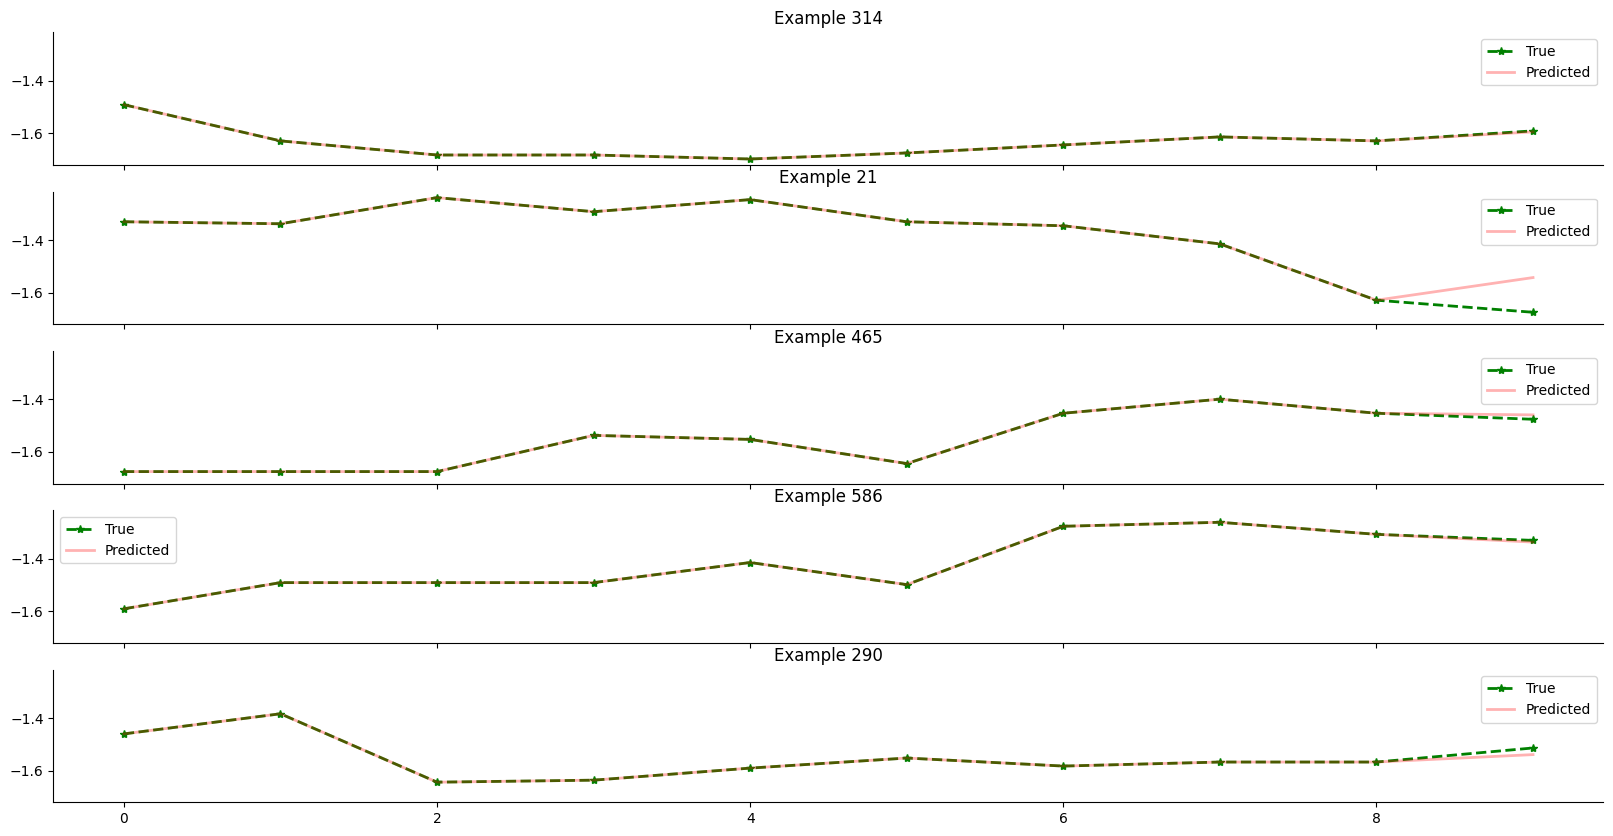

In [42]:
fig, axs = plt.subplots(
    len(arma_random_indices), 1, sharey=True, sharex="col", figsize=(20, len(arma_random_indices) * 2)
)
for i, ri in enumerate(arma_random_indices):
    act = np.concatenate((arma_summary[ri][0], arma_summary[ri][1]), axis=0)
    fcast = np.concatenate((arma_summary[ri][0], arma_summary[ri][2]), axis=0)
    axs[i].plot(act[-last_pts:, :], label="True", linestyle="--", color="green", marker="*", linewidth=2)
    axs[i].plot(fcast[-last_pts:, :], label="Predicted", linestyle="-", color="red", linewidth=2, alpha=0.3)
    axs[i].set_title(f"Example {random_indices[i]}")
    # axs[i].set_ylim(-3, 3)
    for s in ["top", "right"]:
        axs[i].spines[s].set_visible(False)
    axs[i].legend()